

# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---


### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).


### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.


#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot

In [4]:
import requests
import bs4
from bs4 import BeautifulSoup

In [5]:
np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [7]:
## YOUR CODE HERE
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

In [8]:
r.status_code
# The returned code of 200 tells us that the page downloaded successfully. 

200

In [9]:
results = soup.find_all('div', attrs = {'class': 'job_seen_beacon'})

In [10]:
len(results)

15

In [11]:
print(results[0].prettify())

<div class="job_seen_beacon">
 <table cellpadding="0" cellspacing="0" class="jobCard_mainContent big6_visualChanges" role="presentation">
  <tbody>
   <tr>
    <td class="resultContent">
     <div class="heading4 color-text-primary singleLineTitle tapItem-gutter">
      <h2 class="jobTitle jobTitle-color-purple jobTitle-newJob">
       <div class="new topLeft holisticNewBlue desktop">
        <span class="label">
         new
        </span>
       </div>
       <span title="Data Scientist">
        Data Scientist
       </span>
      </h2>
     </div>
     <div class="heading6 company_location tapItem-gutter companyInfo">
      <span class="companyName">
       <a class="turnstileLink companyOverviewLink" data-tn-element="companyName" href="/cmp/Candy" rel="noopener" target="_blank">
        CANDY
       </a>
      </span>
      <span class="ratingsDisplay withRatingLink">
       <a aria-label="Company rating 4.3 out of 5 stars" class="ratingLink" data-tn-variant="cmplinktst2" href="/

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [12]:
location = []
def location_func(results):
        try:
            location.append(result.find('div', attrs = {'class': 'companyLocation'}).text.strip())
        except:
            location.append(np.nan)

for result in results:
    location_func(result)
print(location)


['New York, NY', 'Remote in New York, NY', 'New York, NY 10041 10041 (Financial District area)+3 locations', 'Remote in New York, NY', 'New York, NY 10018 10018 (Garment District area)', 'Remote in New York, NY', 'New York, NY', 'New York, NY', 'New York, NY 10011 10011 (Chelsea area)', 'New York, NY 10022 10022 (Midtown area)+1 location', 'Remote in Vienna, NY', 'Remote in New York, NY 10018 10018', 'New York, NY 10017 10017 (Turtle Bay area)', 'New York, NY 10017 10017 (Midtown area)', 'Remote in New York, NY']


In [13]:

company = []

def company_func(results):
        try:
            company.append(result.find('span', attrs = {'class': 'companyName'}).text.strip())
        except:
            company.append(np.nan)


for result in results:
    company_func(result)
print(company)

['CANDY', 'Codecademy', 'S&P Global', 'AlphaSights', 'QuaEra', 'Quizlet', 'Conde Nast', 'Balyasny', 'Sightly Enterprises', 'the NBA', 'TrueChoice Solutions', 'Happy Returns', 'Guidepoint Global', 'TikTok', 'BlockFi']


In [14]:
job = []


def job_func(results):
        try:
            job.append(result.find('span', 'title' == True).text.strip())
        except:
            job.append(np.nan)


for result in results:
    job_func(result)
print(job)

['Data Scientist', 'Data Scientist', 'Associate, Data Scientist', 'Data Scientist (Remote) - US', 'Data Scientist', 'Data Scientist, Machine Learning (Remote)', 'Senior Data Scientist (Data Scientist III)', 'Junior Data Scientist - BAM Elevate', 'DATA SCIENTIST', 'Data Scientist, Game Analytics & Strategy', '(Jr) Quantitative Analyst / Data Scientist', 'Data Scientist', 'Healthcare Data Scientist - Claims', 'Data Scientist, TikTok Creation and Consumption', 'Fraud Data Scientist']


In [15]:
salary = []

def salary_func(results):
        try:
            salary.append(result.find('div', attrs = {'class': 'metadata salary-snippet-container'}).text.strip())
        except:
            salary.append(np.nan)


for result in results:
    salary_func(result)
print(salary)

[nan, nan, '$67,600 - $190,100 a year', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [16]:
description = []

def description_func(results):
        try:
            description.append(result.find('div', attrs = {'class': 'job-snippet'}).text.strip())
        except:
            description.append(np.nan)



for result in results:
    description_func(result)
print(description)

['Translate data insights into product recommendations.\nYou will play a major role in owning high impact product areas, driving transparency through reporting,…', 'Work with our data science and engineering teams to maintain data integrity.\nYou have strong data intuition and knowledge of using data science best practices…', 'Extract insights from large textual data sets by developing NLP algorithms.\nDesign and develop data science models to transform diverse datasets into actionable…', 'Work directly with stakeholders and teams to fully understand the business problems and translate it to a data-driven solution.', 'Experience with R, Python, PySpark and data visualization software such as Tableau.\nAbility to efficiently construct data sets from large scale distributed…', 'As an ML Data Scientist working on ads, you will be working with other data scientists, product managers, product, engineering, and sales to build an amazing…', 'Work closely with data engineers and machine learni

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [18]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
uk_url =  "https://uk.indeed.com/jobs?q=data%20scientist&l={city}&start={start}"
max_results_per_city = 650# Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in tqdm(set(['London','Bristol','Oxford' ,'Chester','Bradford','Wakefield','Sheffield','Leeds' ,'Glasgow','Manchester',
                                            'Edinburgh','Warwick','Birmingham','Blackburn' ,'Coventry','Doncaster','Leicester',
                                            'Stockport','Nottingham','Salford'])):
    print('printing:', city)
    for start in range(0, max_results_per_city, 10):
        url = f"https://uk.indeed.com/jobs?q=data%analyst&l={city}&start={start}"
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        time.sleep(random.randint(1,7))
        for item in soup.find_all('div', attrs = {'class': 'job_seen_beacon'}):
            results.append(item)


  0%|                                                    | 0/20 [00:00<?, ?it/s]

printing: Wakefield


  0%|                                                    | 0/20 [00:23<?, ?it/s]


KeyboardInterrupt: 

The optimal search parameter was the max_results_per_city = 650. When yu manually go on the website it doesnt give you an option to go to page 66. 

With this setting I managed to scrape the most results and each scrape took less than 2 hours. 

In [ ]:
def company_func(results):
    company = []
    location = []
    job = []
    salary = []
    description = []
    
    for result in results:
        try:
            location.append(result.find('div', attrs = {'class': 'companyLocation'}).text.strip())
            company.append(result.find('span', attrs = {'class': 'companyName'}).text.strip())
            job.append(result.find('span', 'title' == True).text.strip())
            description.append(result.find('div', attrs = {'class': 'job-snippet'}).text.strip())
            salary.append(result.find('div', attrs = {'class': 'metadata salary-snippet-container'}).text.strip())
        except:
            salary.append(np.nan)
      
    table = pd.DataFrame({
        'Company': company,
        'Location': location,
        'Job': job,
        'Salary': salary,
        'Description': description})
    return table

In [ ]:
df = company_func(results)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [19]:
all_files =['uk1.csv','uk2.csv','uk3.csv']

In [20]:
# These CSVs combine my searched and now I am combining them. to proceed with the data cleaning. 

In [21]:
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [22]:
# The for loop iterates itirates through the list of CSVs and creates a dataframe of them all combined. 

In [23]:
frame.shape

(29248, 6)

In [24]:
frame.head()

,Unnamed: 0,Company,Location,Job,Salary,Description
0,0,Direct Line Group,Leeds,Fraud Data Scientist,NaN,This is an ideal role for someone keen to deve...
1,1,Health & Safety Executive,Leeds•Remote,Text Analyst / Data Scientist,"£39,334 - £45,865 a year","Previous experience as a text analyst, data sc..."
2,2,Lumilinks,United Kingdom•Remote,Data Scientist,"£30,000 - £40,000 a year",We’ve got massive plans to disrupt the data in...
3,3,Easysoft Ltd,Wetherby LS23,Data Scientist (ref 081),NaN,"Design, develop, implement and maintain data m..."
4,4,TransUnion,Leeds,Analytics Consultant,NaN,Submit and analyse retrospective bureau data.\...


In [25]:
frame = frame.drop('Unnamed: 0',axis=1)

In [26]:
# This column is there because when I was originally saving the results in the CSV I did not specify  index_col parameter.
# All 3 concatenated CSVs had this column, so I was able to drop it.

In [27]:
frame.head()

,Company,Location,Job,Salary,Description
0,Direct Line Group,Leeds,Fraud Data Scientist,NaN,This is an ideal role for someone keen to deve...
1,Health & Safety Executive,Leeds•Remote,Text Analyst / Data Scientist,"£39,334 - £45,865 a year","Previous experience as a text analyst, data sc..."
2,Lumilinks,United Kingdom•Remote,Data Scientist,"£30,000 - £40,000 a year",We’ve got massive plans to disrupt the data in...
3,Easysoft Ltd,Wetherby LS23,Data Scientist (ref 081),NaN,"Design, develop, implement and maintain data m..."
4,TransUnion,Leeds,Analytics Consultant,NaN,Submit and analyse retrospective bureau data.\...


In [28]:
frame = frame.drop_duplicates(keep=False)

In [29]:
# First, I will be dropping the duplicates before proceeding with the data cleaning.

In [30]:
frame.shape

(3114, 5)

In [31]:
# We can see that the majority of the rows were duplicates.

In [32]:
frame.isna().sum()

Company           1
Location          0
Job               0
Salary         1970
Description       0
dtype: int64

In [33]:
frame = frame.dropna()

In [34]:
# Now, I will be dropping the rows that are missing the information on the salary.

In [35]:
frame.shape

(1143, 5)

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(frame['Salary'])

1          £39,334 - £45,865 a year
8                    £27,000 a year
3648       £38,000 - £48,000 a year
3651           Up to £60,000 a year
3654       £21,000 - £26,000 a year
3659       £35,327 - £40,928 a year
3660       £31,931 - £34,709 a year
3661            From £33,000 a year
3662           Up to £78,000 a year
6015       £50,000 - £55,000 a year
6173       £55,000 - £65,000 a year
6240       £50,000 - £55,000 a year
6262     £100,000 - £115,000 a year
6278                     £650 a day
6282       £65,000 - £85,000 a year
6283       £55,000 - £60,000 a year
6306       £60,000 - £80,000 a year
6312      £55,000 - £100,000 a year
6313       £50,000 - £60,000 a year
6315      £50,000 - £100,000 a year
6317       £80,000 - £93,500 a year
6393       £55,000 - £75,000 a year
6395       £45,000 - £55,000 a year
6396       £34,304 - £40,927 a year
6399                 £55,000 a year
6424       £80,000 - £95,000 a year
6429       £50,000 - £80,000 a year
6483       £30,000 - £50,000

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [37]:
frame = frame[~frame.Salary.str.contains('hour')].copy()

In [38]:
frame = frame[~frame.Salary.str.contains('month')].copy()

In [39]:
frame = frame[~frame.Salary.str.contains('day')].copy()

In [40]:
frame = frame[~frame.Salary.str.contains('week')].copy()

In [41]:
# Next, I am dropping all the rows that have data on the salary but it is not yearly.
# I could convert it into a yearly salary but my assumption is that the hourly rate for contractual work is much higher. 

In [42]:
frame.Salary

1        £39,334 - £45,865 a year
8                  £27,000 a year
3648     £38,000 - £48,000 a year
3651         Up to £60,000 a year
3654     £21,000 - £26,000 a year
                   ...           
28698    £40,000 - £50,000 a year
28718    £38,000 - £40,000 a year
29064    £28,000 - £35,000 a year
29131    £30,000 - £40,000 a year
29135    £30,000 - £35,000 a year
Name: Salary, Length: 1037, dtype: object

In [43]:
frame['clean_salary'] = frame['Salary'].str.replace(r'Up|to|an?|year|£|From|,','')

In [44]:
# I am creating a new column with the salary data but without characters that are not numbers. I have kept "-", because I will use this later to split my data.

In [45]:
frame['clean_salary'] 

1        39334 - 45865  
8                27000  
3648     38000 - 48000  
3651             60000  
3654     21000 - 26000  
              ...       
28698    40000 - 50000  
28718    38000 - 40000  
29064    28000 - 35000  
29131    30000 - 40000  
29135    30000 - 35000  
Name: clean_salary, Length: 1037, dtype: object

In [46]:
frame[['A','B']] = frame['clean_salary'].str.split("-", expand=True)

In [47]:
frame[['A','B']]

,A,B
1,39334,45865
8,27000,None
3648,38000,48000
3651,60000,None
3654,21000,26000
...,...,...
28698,40000,50000
28718,38000,40000
29064,28000,35000
29131,30000,40000


In [48]:
frame['B']  = frame['B'].replace(np.nan, 0)

In [49]:
frame['B'][frame['B'] == 0] = frame['A']

In [50]:
frame[['A','B']] = frame[['A','B']].astype('int')

In [51]:
frame['B'] = (frame['B'] +  frame['A'])/2

In [52]:
frame['clean_salary'] = frame['B'] 

In [53]:
frame = frame.drop(['A','B'],axis=1)

In [54]:
# I have created two news columns for salary: 'A' for lower range for salaries with the range or for salary value if there is no range.
# Column 'B' if for the higher end of the range. It is 'None' for rows that don't have a range but have one salary value.
# Next, I am replacing None with 0 and then converting the columns to 'int' type columns.
# In order to input average salary to 'clean_salary' column, I am replacing the '0' values with the 'A' column values and then calculating the mean of "A" and "B"
# I am dropping the 'A' and 'B' columns as they were only used for calculations and the column 'clean_salary' now has the data we want to use. 

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(frame['clean_salary'])

1         42599.5
8         27000.0
3648      43000.0
3651      60000.0
3654      23500.0
3659      38127.5
3660      33320.0
3661      33000.0
3662      78000.0
6015      52500.0
6173      60000.0
6240      52500.0
6262     107500.0
6282      75000.0
6283      57500.0
6306      70000.0
6312      77500.0
6313      55000.0
6315      75000.0
6317      86750.0
6393      65000.0
6395      50000.0
6396      37615.5
6399      55000.0
6424      87500.0
6429      65000.0
6483      40000.0
6519      80000.0
6523      90000.0
6549      87500.0
6550      38989.5
6561      30000.0
6847     127500.0
6851      17500.0
6852      90000.0
6872     110000.0
6885      65000.0
6888      50000.0
7373      70000.0
7381      85000.0
7667      65000.5
7798      57500.0
8239     107500.0
8972      27000.0
10498     65000.0
10501     50000.0
10690     46222.5
13224     50000.0
13225     35000.0
14197     65000.0
14200     50000.0
14206     33696.0
14214     33696.0
14218     33696.0
14221     50200.0
14224     

In [56]:
frame.dtypes

Company          object
Location         object
Job              object
Salary           object
Description      object
clean_salary    float64
dtype: object

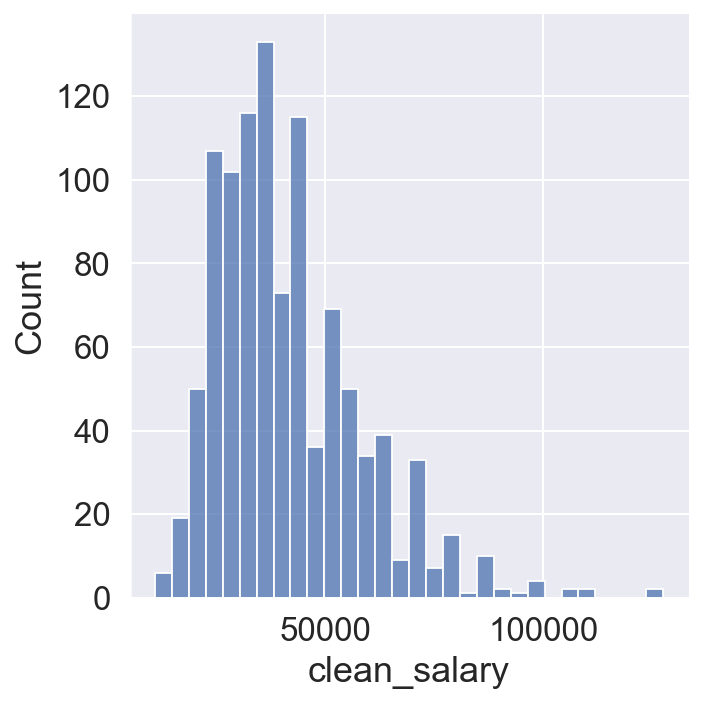

In [57]:
sns.displot(frame['clean_salary']);

In [58]:
# Clean salary is skewed. I would normalize this column if I was performing a linear regression predicting the salary.

In [59]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(frame['Location'].sort_values())

23492                                           Abbey Wood
28349                                        Alderley Edge
28296                                           Altrincham
28171                                           Altrincham
20962                        Altrincham•Temporarily Remote
26866                                    Ashby-De-La-Zouch
26909                                           Atherstone
26967                                   Atherstone CV9 2SQ
26282                                Atherstone+1 location
26529                                               Bardon
23586                                          Barlborough
25146                                             Barnsley
24825                  Barnsley S75 1JN•Temporarily Remote
24472                          Barnsley+2 locations•Remote
23561                                      Barnsley•Remote
18923                                                 Bath
27486                                                 Ba

In [60]:
frame['Location'] = frame['Location'].apply(lambda x: 'London' if 'London' in x else 
                                            'Bristol' if 'Bristol' in x else
                                            'Oxford' if 'Oxford' in x else
                                            'London' if 'Westminster' in x else
                                            'Chester' if 'Chester' in x else
                                            'Bradford' if 'Bradford' in x else
                                            'Wakefield' if 'Wakefield' in x else
                                            'Sheffield' if 'Sheffield' in x else
                                            'Leeds' if 'Leeds' in x else
                                            'Glasgow' if 'Glasgow' in x else
                                            'Manchester' if 'Manchester' in x else
                                            'Edinburgh' if 'Edinburgh' in x else
                                            'Warwick' if 'Warwick' in x else
                                            'Birmingham' if 'Birmingham' in x else
                                            'Blackburn' if 'Blackburn' in x else
                                            'Coventry' if 'Coventry' in x else
                                            'Doncaster' if 'Doncaster' in x else
                                            'Leicester' if 'Leicester' in x else
                                            'Stockport' if 'Stockport' in x else
                                            'Nottingham' if 'Nottingham' in x else
                                            'Salford' if 'Salford' in x else
                                             x)

In [61]:
# Cleaning the Location column with lambda for the main cities in the list. 

In [62]:
frame['Location'] = frame['Location'].str.replace(r'\b[A-ZA-Z0-9]{3}\b|\b[A-ZA-Z0-90-9]{4}\b','')

In [63]:
# The Regex code above cleans the data of all the postcodes in the Location column.

In [64]:
frame['Location'] = frame['Location'].str.replace(r'Remote|•|YO|Temporarily|locations?|[+1]|[+2]|Greater','')

In [65]:
frame['Location'] = frame['Location'].str.strip()

In [66]:
# Getting rid of the spaces before and after the letter characters in the column. 

In [67]:
## YOUR CODE HERE
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(frame['Location'].sort_values())

23492                 Abbey Wood
28349              Alderley Edge
20962                 Altrincham
28296                 Altrincham
28171                 Altrincham
26866          Ashby-De-La-Zouch
26282                 Atherstone
26909                 Atherstone
26967                 Atherstone
26529                     Bardon
23586                Barlborough
24472                   Barnsley
23561                   Barnsley
25146                   Barnsley
24825                   Barnsley
27486                       Bath
18923                       Bath
27504                       Bath
27574                       Bath
28179                  Birchwood
26121                 Birmingham
26483                 Birmingham
26482                 Birmingham
26481                 Birmingham
26473                 Birmingham
26470                 Birmingham
26090                 Birmingham
26459                 Birmingham
26484                 Birmingham
26456                 Birmingham
26448     

In [68]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(frame['Job'].sort_values())

24312    2nd Line Support Team Leader / 2nd Line Suppor...
25072                   2nd Line Systems Analyst - REF 860
27645                      3rd Level Cisco Support Analyst
25545                                           AV Analyst
26142                          Accounts Receivable Analyst
29135                                    Actuarial Analyst
26517                                    Actuarial Analyst
28633     Actuarial Analyst (Actuarial exams not required)
26732                          Administrative Data Analyst
26552                                        Administrator
25645                Administrator (Fire Safety Technical)
26987                            Administrator / Scheduler
23587                  Advanced Public Health Practitioner
24376                              Amazon Contract Manager
22992                                              Analyst
23327                                              Analyst
22956                                              Analy

### Save your results as a CSV

In [69]:
#frame.to_csv('Copy1.csv', index=False)

In [70]:
# This CSV now has the cleaned combined data from the original CSVs

### Load in the the data of scraped salaries

In [71]:
frame1 = pd.read_csv('Copy1.csv')

In [72]:
frame1.head()

,Company,Location,Job,Salary,Description,clean_salary
0,Health & Safety Executive,Leeds,Text Analyst / Data Scientist,"£39,334 - £45,865 a year","Previous experience as a text analyst, data sc...",42599.5
1,Hermes,Leeds,Data Analyst Graduate,"£27,000 a year","Keep up to date with trends in data science, l...",27000.0
2,Glass Futures,St Helens,Data Scientist & Data Engineer,"£38,000 - £48,000 a year",*Company description* About us: Glass Futures ...,43000.0
3,Sykes Cottages,Chester,Analytics Manager,"Up to £60,000 a year","At Sykes Holiday Cottages, we are experiencing...",60000.0
4,Agility Resourcing,Chester,Graduate Data Analyst/Scientist,"£21,000 - £26,000 a year",My client is a SME consultancy organisation wh...,23500.0


### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [73]:
median_sal = frame1.clean_salary.median()

def high_low(x):
    if x < median_sal:
        return 'Low'
    else:
        return 'High'

In [74]:
frame1['high_low'] = frame1['clean_salary'].apply(high_low)

In [75]:
# I created a new column that has a value of 'High' for salaries that are above the median and 'Low' for the below the median.

In [76]:
frame1.head()

,Company,Location,Job,Salary,Description,clean_salary,high_low
0,Health & Safety Executive,Leeds,Text Analyst / Data Scientist,"£39,334 - £45,865 a year","Previous experience as a text analyst, data sc...",42599.5,High
1,Hermes,Leeds,Data Analyst Graduate,"£27,000 a year","Keep up to date with trends in data science, l...",27000.0,Low
2,Glass Futures,St Helens,Data Scientist & Data Engineer,"£38,000 - £48,000 a year",*Company description* About us: Glass Futures ...,43000.0,High
3,Sykes Cottages,Chester,Analytics Manager,"Up to £60,000 a year","At Sykes Holiday Cottages, we are experiencing...",60000.0,High
4,Agility Resourcing,Chester,Graduate Data Analyst/Scientist,"£21,000 - £26,000 a year",My client is a SME consultancy organisation wh...,23500.0,Low


#### Thought experiment: What is the baseline accuracy for this model?

In [77]:
## The base line accuracy for this model is almost 50/50 but not quite!
frame1.high_low.value_counts(normalize = True)

High    0.520733
Low     0.479267
Name: high_low, dtype: float64

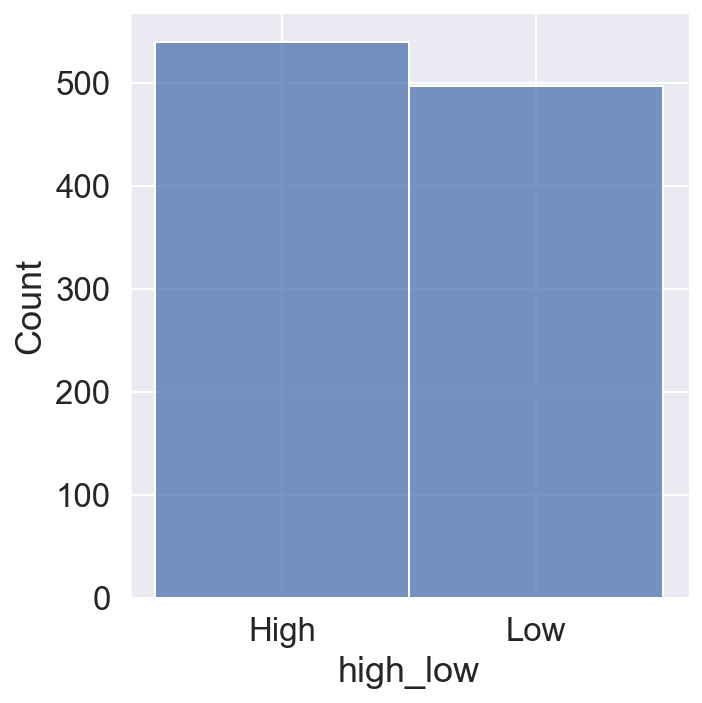

In [78]:
sns.displot(frame1['high_low']);

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [79]:
X = frame1['Location']
y = frame1['high_low']

In [80]:
X = pd.get_dummies(X, columns =['Location'], drop_first=True)

In [81]:
scaler = StandardScaler()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [83]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                       columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), 
                      columns=X_train.columns)

In [84]:
knn = KNeighborsClassifier(n_neighbors=5)

print("KNN CV training score:\t", 
      cross_val_score(knn, X_train, y_train, cv=5,
                    n_jobs=2).mean())
knn.fit(X_train, y_train)
print("KNN training score:\t", knn.score(X_train, y_train))
print("KNN test score:\t", knn.score(X_test, y_test))

KNN CV training score:	 0.5065863453815261
KNN training score:	 0.5971049457177322
KNN test score:	 0.5384615384615384


In [85]:
# KNN model is performing worse than the baseline accuracy based on the CV training score. 

In [86]:
model = DecisionTreeClassifier()

In [87]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [88]:
scores = cross_val_score(model, X_train, y_train, cv=5)

print(model.score(X_train, y_train))
print(scores)
print(np.mean(scores))
print(model.score(X_test, y_test))

0.6743063932448733
[0.6325 0.5843 0.6446 0.5964 0.5636]
0.6042935377875136
0.5432692307692307


In [89]:
# DecisionTreeClassifier is performing better than the baseline based on the CV training score so I will run a grid search on it. 

In [90]:
dtc_params = {
    'max_depth': [None]+list(range(1, 5)),
    'max_features': range(1, X.shape[1]+1),
    'min_samples_split': [2, 3, 4, 5],
    'ccp_alpha': [0, 0.0001, 0.001]
}

In [91]:
dtc_gs = GridSearchCV(model, dtc_params, cv=5,
                      verbose=1, n_jobs=2, return_train_score=True)

In [92]:
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 8460 candidates, totalling 42300 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001],
                         'max_depth': [None, 1, 2, 3, 4],
                         'max_features': range(1, 142),
                         'min_samples_split': [2, 3, 4, 5]},
             return_train_score=True, verbose=1)

In [93]:
b = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'ccp_alpha': 0.001, 'max_depth': None, 'max_features': 24, 'min_samples_split': 4}
0.6115370573201898


In [94]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': b.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
19,Cambridge,0.132102
73,London,0.129419
79,Manchester,0.072904
14,Bristol,0.044097
20,Cambridgeshire,0.039228
...,...,...
47,Garforth,0.000000
46,Feltham,0.000000
45,Falkirk,0.000000
44,Euxton,0.000000


In [95]:
# In scikit-learn the feature importance is the decrease in node impurity. The key is that it measures the importance only at a node level. 
# Then, all the nodes are weighted by how many samples reach that node.
# As per the table above, the majority of samples reached the cities with the most job vacancies. 

In [96]:
# Nex I will create binary columns based on the certain words being present in the 'Job Title' column.

In [97]:
frame1['junior'] = frame1['Job'].apply(lambda x: 1 if 'Junior' in x else 0)

In [98]:
frame1['junior'].value_counts(normalize = True)

0    0.976856
1    0.023144
Name: junior, dtype: float64

In [99]:
frame1['senior'] = frame1['Job'].apply(lambda x: 1 if 'Senior' in x else 0)

In [100]:
frame1['senior'].value_counts(normalize = True)

0    0.893925
1    0.106075
Name: senior, dtype: float64

In [101]:
frame1['grad'] = frame1['Job'].apply(lambda x: 1 if 'Graduate' in x else 0)

In [102]:
frame1['grad'].value_counts(normalize = True)

0    0.972999
1    0.027001
Name: grad, dtype: float64

In [103]:
frame1['analyst'] = frame1['Job'].apply(lambda x: 1 if 'Analyst' in x else 0)

In [104]:
frame1['analyst'].value_counts(normalize = True)

1    0.594986
0    0.405014
Name: analyst, dtype: float64

In [105]:
frame1['science'] = frame1['Job'].apply(lambda x: 1 if 'Scientist' in x else 0)

In [106]:
frame1['science'].value_counts(normalize = True)

0    0.900675
1    0.099325
Name: science, dtype: float64

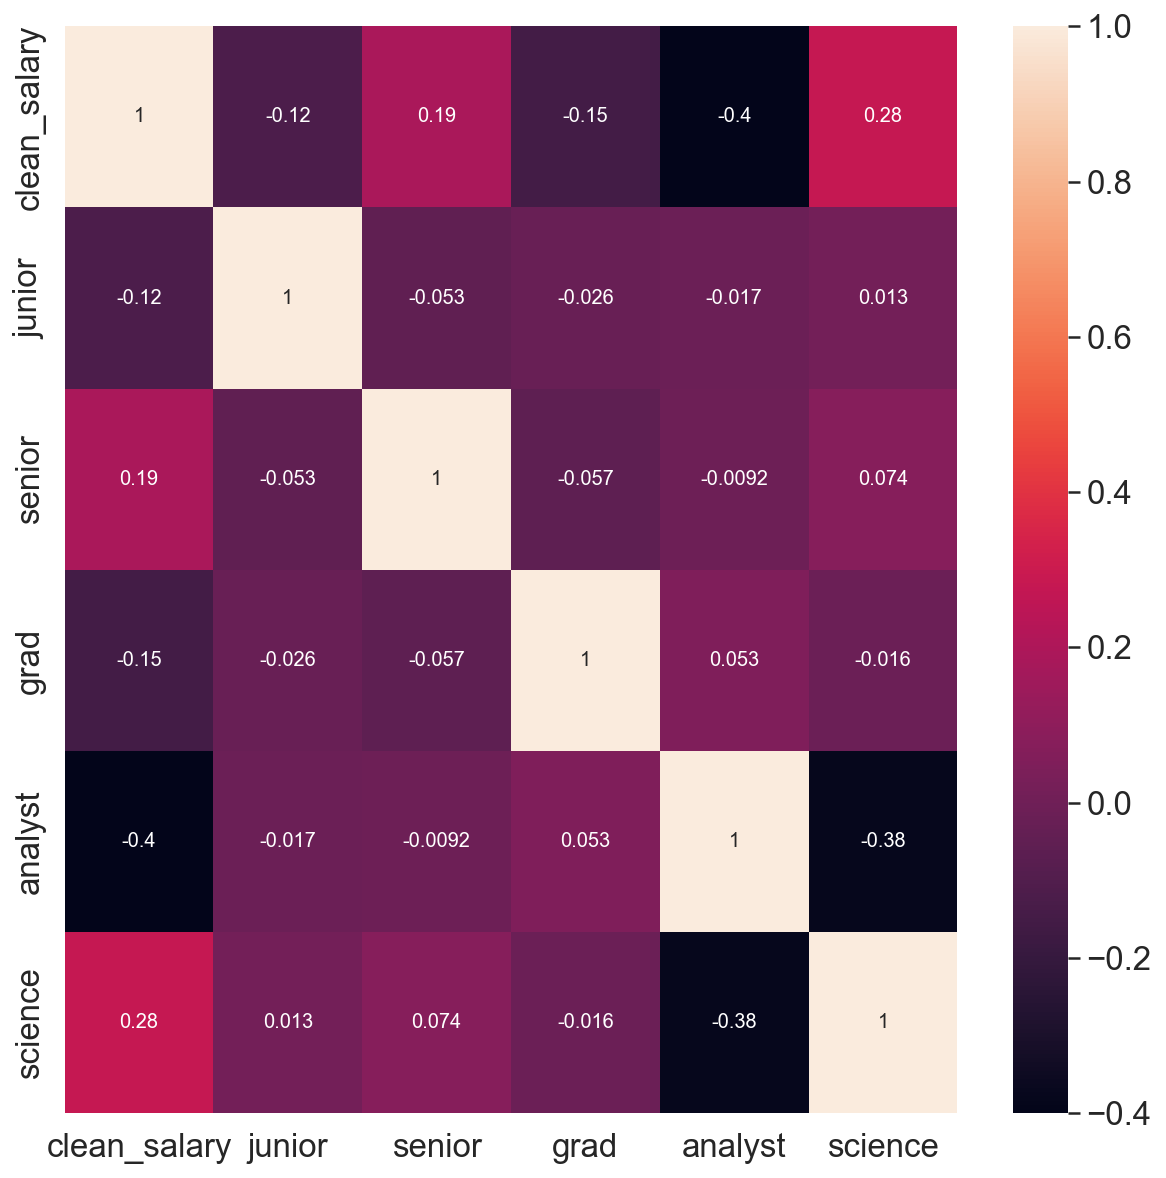

In [107]:
corrmat = frame1.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, annot=True);

In [108]:
# None of the parameters seems to have a particularly high correlation, so I can use them all for my next model. 

In [109]:
X = frame1[['Location','junior','senior','grad','analyst','science']]
y = frame1['high_low']

In [110]:
X = pd.get_dummies(X,columns = ['Location'],drop_first=True)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [112]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                       columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), 
                      columns=X_train.columns)

In [113]:
knn = KNeighborsClassifier(n_neighbors=5)

print("KNN CV training score:\t", 
      cross_val_score(knn, X_train, y_train, cv=5,
                    n_jobs=2).mean())
knn.fit(X_train, y_train)
print("KNN training score:\t", knn.score(X_train, y_train))
print("KNN test score:\t", knn.score(X_test, y_test))

KNN CV training score:	 0.6248703906535232
KNN training score:	 0.7044632086851629
KNN test score:	 0.6009615384615384


In [114]:
# This time KNN has a much better performace. The extra parameters increased the CV training score by 0,13.

In [115]:
knn_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
knn_gridsearch = GridSearchCV(knn,
                              knn_params,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

In [116]:
k = knn_gridsearch.best_estimator_
print(knn_gridsearch.best_params_)
print(knn_gridsearch.best_score_)
print("KNN CV training score:\t", 
      cross_val_score(k, X_train, y_train, cv=5,
                    n_jobs=2).mean())

{'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'distance'}
0.6888134355604236
KNN CV training score:	 0.6888134355604236


In [117]:
# The best KNN CV training score that I was able to achieve with grid search is 0.69 which is much better than the original KNN score. 

In [118]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)

print("DecisionTreeClassifier CV training score:\t", 
      cross_val_score(model, X_train, y_train, cv=5,
                    n_jobs=2).mean())
print("DecisionTreeClassifier training score:\t", model.score(X_train, y_train))
print("DecisionTreeClassifier test score:\t", model.score(X_test, y_test))

DecisionTreeClassifier CV training score:	 0.6888061336254107
DecisionTreeClassifier training score:	 0.7840772014475271
DecisionTreeClassifier test score:	 0.5865384615384616


In [119]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
3,analyst,0.230779
1,senior,0.102076
2,grad,0.056474
0,junior,0.034940
41,Location_Derby,0.024501
...,...,...
94,Location_Pinner,0.000000
51,Location_Feltham,0.000000
54,Location_Greenwich,0.000000
91,Location_Oldbury,0.000000


In [120]:
dtc_params = {
    'max_depth': [None]+list(range(1, 5)),
    'max_features': range(1, X.shape[1]+1),
    'min_samples_split': [2, 3, 4, 5],
    'ccp_alpha': [0, 0.0001, 0.001]
}

In [121]:
dtc_gs = GridSearchCV(model, dtc_params, cv=5,
                      verbose=1, n_jobs=-2, return_train_score=True)
dtc_gs.fit(X_train, y_train)
b = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

Fitting 5 folds for each of 8760 candidates, totalling 43800 fits
{'ccp_alpha': 0.001, 'max_depth': 4, 'max_features': 73, 'min_samples_split': 4}
0.6984519897772911


In [122]:
print("DecisionTreeClassifier CV training score:\t", 
      cross_val_score(b, X_train, y_train, cv=5,
                    n_jobs=2).mean())

DecisionTreeClassifier CV training score:	 0.6888134355604236


In [123]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': b.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
3,analyst,0.395409
1,senior,0.202195
4,science,0.171337
2,grad,0.113380
0,junior,0.033967
...,...,...
48,Location_Edinburgh,0.000000
47,Location_East Midlands Airport,0.000000
46,Location_Duxford,0.000000
45,Location_Droitwich,0.000000


In [124]:
# Again, feature importance is the decrease in node impurity. The key is that it measures the importance only at a node level. 
# Then, all the nodes are weighted by how many samples reach that node.


### Model evaluation:


In [125]:
## YOUR CODE HERE
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, accuracy_score

Using Precision-Recall curve for various Decision Threshold values, we can select the best value for Decision Threshold such that it gives High Precision ( Without affection Recall much ) or High Recall ( Without affecting Precision much ) based on whether our project is precision-oriented or recall-oriented respectively.

In [141]:
model = LogisticRegression()
model.fit(X_train, y_train)
predict_actual = model.predict(X_test)       # Predict using classifier.
accuracy_actual = model.score(X_test, y_test)
classification_report_actual = classification_report(y_test, predict_actual)
print(predict_actual, accuracy_actual, classification_report_actual, sep ='\n')

['Low' 'High' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'High' 'Low' 'High'
 'Low' 'Low' 'Low' 'Low' 'High' 'High' 'Low' 'High' 'Low' 'High' 'Low'
 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'High' 'High' 'Low' 'Low' 'High'
 'High' 'Low' 'Low' 'High' 'High' 'High' 'High' 'High' 'High' 'Low' 'Low'
 'Low' 'High' 'Low' 'High' 'High' 'High' 'Low' 'Low' 'Low' 'High' 'Low'
 'Low' 'Low' 'High' 'Low' 'High' 'Low' 'High' 'High' 'Low' 'Low' 'Low'
 'High' 'Low' 'High' 'Low' 'Low' 'High' 'High' 'High' 'Low' 'Low' 'Low'
 'High' 'High' 'High' 'High' 'High' 'High' 'Low' 'Low' 'High' 'Low' 'Low'
 'Low' 'Low' 'Low' 'High' 'Low' 'High' 'High' 'High' 'Low' 'Low' 'Low'
 'High' 'High' 'Low' 'Low' 'High' 'Low' 'Low' 'High' 'High' 'Low' 'Low'
 'Low' 'High' 'Low' 'High' 'High' 'Low' 'Low' 'Low' 'Low' 'High' 'Low'
 'High' 'High' 'High' 'Low' 'Low' 'High' 'Low' 'High' 'Low' 'High' 'High'
 'Low' 'Low' 'High' 'Low' 'High' 'Low' 'Low' 'High' 'Low' 'Low' 'Low'
 'Low' 'Low' 'High' 'Low' 'High' 'High' 'Low' 'Low' 'Low' 'High' 'Lo

In the above classification report, we can see that our model precision value for 'High' is 0.70 and recall is 0.58. 

Since our goal is to build a High-Precision ML model in predicting 'High' , we need to manually select the best value of Decision Threshold value form the below Precision-Recall curve, so that we could increase the precision of this model.

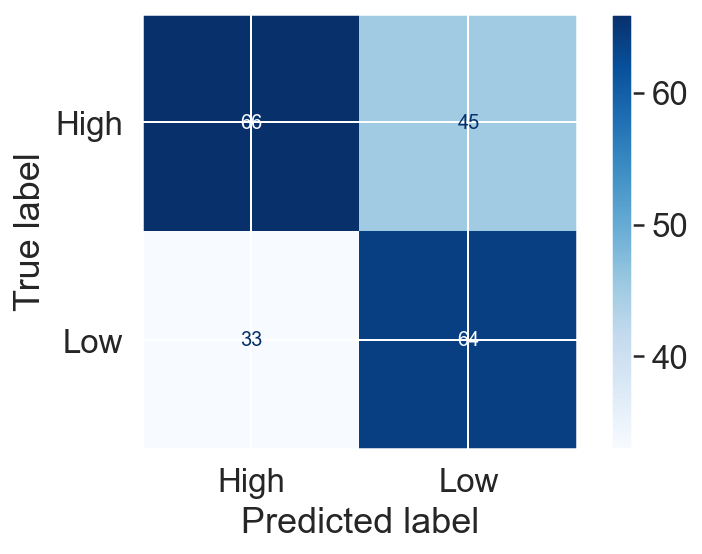

In [142]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_actual)
metrics.plot_confusion_matrix(b, X_test, y_test, cmap='Blues')
plt.show()

In [143]:
# The model predicted 64 Low salaries correcly. 
# The model predicted 66 High salaries coreclty.

Each row of our data will be classified as Default=True or Default=False. The logistic regression assigns each row a probability of bring True and then makes a prediction for each row where that prbability is >= 0.5 i.e. 0.5 is the default threshold.

In [144]:
decision_function = model.decision_function(X_test)

In [145]:
# This method basically returns a Numpy array, In which each element represents whether a predicted sample for 
# x_test by the classifier lies to the right or left side of the Hyperplane and also how far from the HyperPlane.

In [146]:
from sklearn.metrics import precision_recall_curve

In [147]:
precision, recall, threshold = precision_recall_curve(y_test, decision_function, pos_label='High')

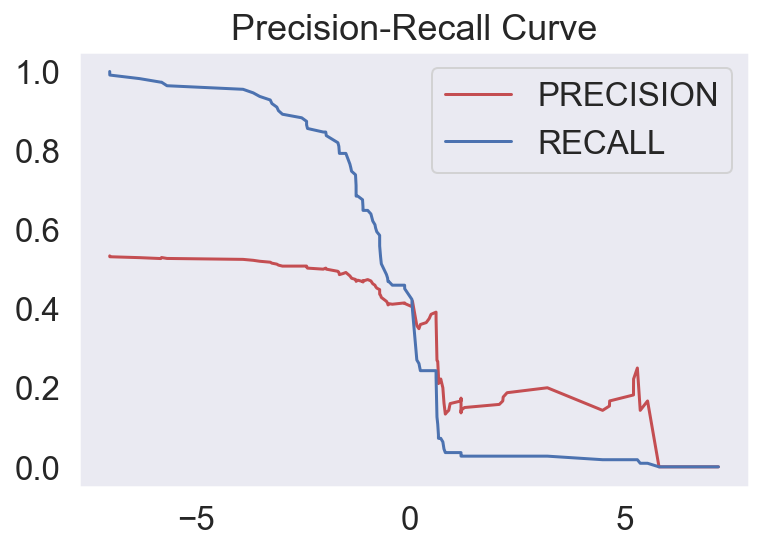

In [148]:
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve');

Here in the above plot, we can see that if we want high precision value, then we need to increase the value of decision threshold ( x-axis ), so we need to choose that value of Decision Threshold which would increase Precision but not much decrease in Recall. One such value form the above plot is around 0.6 Decision Threshold.

In [149]:
# Unfortunately, you can’t have both precision and recall high. If you increase precision, it will reduce recall, and vice versa. 
# This is called the precision/recall tradeoff.

# Precision is the ratio of correct predictions for one class out of all positive predictions made for that class.

# As a result, recall is reduced. Recall is the number of true positives divided by the total number of elements 
# that actually belong to the positive class. 